In [1]:
import nibabel as nib 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from skimage.metrics import mean_squared_error as mse
from scipy.spatial.distance import jensenshannon
import pandas as pd
from tqdm import tqdm
from math import log10
from scipy.stats import entropy
from scipy.interpolate import make_interp_spline
from scipy.stats import rankdata
from ridgeplot import ridgeplot
import ptitprince as pt
from scipy.stats import wilcoxon, ranksums, mannwhitneyu

In [2]:
def kl_div(dist1, dist2):
    dist1_hist, dist1_bins = np.histogram(dist1, bins = 10, density = True)
    dist2_hist, dist2_bins = np.histogram(dist2, bins = 10, density = True)
    
    kl = entropy(dist1_hist, dist2_hist)
    return kl

In [3]:
mse_b50ftob30f = {}
mse_bonetostd = {}
kl_bonetob30f = {}
kl_stdtob30f = {}

#Real values
b30f = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/B30f_B50f/soft/emphysema_masked/emph.csv")
b30f = b30f.sort_values(by = "pid")
b50f = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/B30f_B50f/hard/emphysema_masked/emph.csv")
b50f = b50f.sort_values(by = "pid")
bone = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/STANDARD_BONE/hard/emphysema/emph.csv")
bone = bone.sort_values(by = "pid")
std = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/STANDARD_BONE/soft/emphysema/emph.csv")

In [4]:
for i in tqdm(range(2,74,2)):
    b50ftob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "B50ftoB30f_emphysema", "emph.csv"))
    b50ftob30f = b50ftob30f.sort_values(by = "pid")
    bonetob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "BONEtoB30f_emphysema", "emph.csv"))
    bonetob30f = bonetob30f.sort_values(by = "pid")
    stdtob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "STDtoB30f_emphysema", "emph.csv"))
    stdtob30f = stdtob30f.sort_values(by = "pid")
    bonetostd = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "BONEtoSTD_emphysema", "emph.csv"))
    bonetostd = bonetostd.sort_values(by = "pid")

    kl_bonetob30f[i] = kl_div(bonetob30f["emph_score"].values, b30f["emph_score"].values)
    kl_stdtob30f[i] = kl_div(stdtob30f["emph_score"].values, b30f["emph_score"].values)
    mse_b50ftob30f[i] = mse(b50ftob30f["emph_score"].values, b30f["emph_score"].values)
    mse_bonetostd[i] = mse(bonetostd["emph_score"].values, std["emph_score"].values)

100%|██████████| 36/36 [00:02<00:00, 14.79it/s]


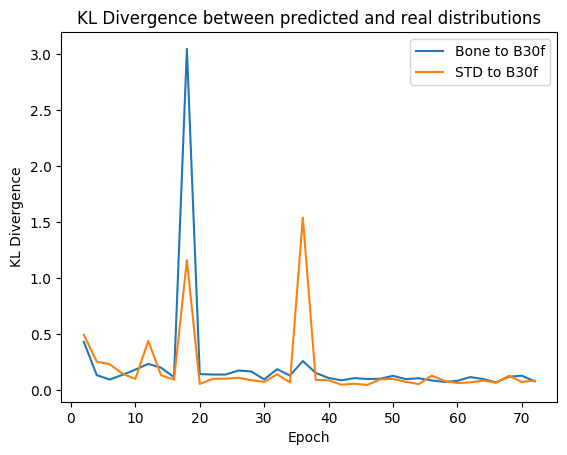

In [5]:
#plot KL divergence
plt.figure()
plt.plot(list(kl_bonetob30f.keys()), list(kl_bonetob30f.values()), label = "Bone to B30f")
plt.plot(list(kl_stdtob30f.keys()), list(kl_stdtob30f.values()), label = "STD to B30f")
plt.xlabel("Epoch")
plt.ylabel("KL Divergence")
plt.legend()
plt.title("KL Divergence between predicted and real distributions")
plt.show()

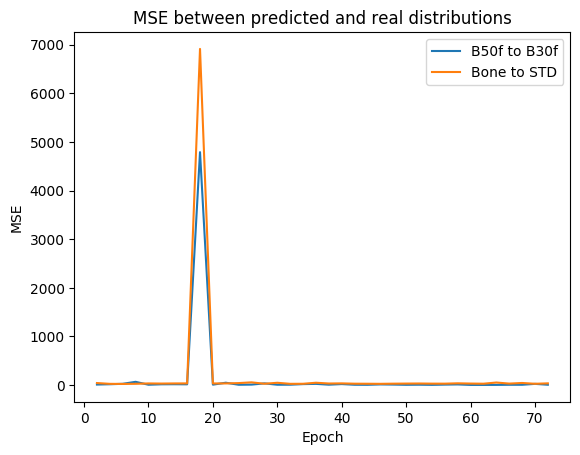

In [6]:
#Plot MSE
plt.figure()
plt.plot(list(mse_b50ftob30f.keys()), list(mse_b50ftob30f.values()), label = "B50f to B30f")
plt.plot(list(mse_bonetostd.keys()), list(mse_bonetostd.values()), label = "Bone to STD")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE between predicted and real distributions")
plt.show()

In [7]:
#Rank the values of the KL divergence and MSE
kl_bonetob30f_rank = rankdata(list(kl_bonetob30f.values()))
kl_stdtob30f_rank = rankdata(list(kl_stdtob30f.values()))
mse_b50ftob30f_rank = rankdata(list(mse_b50ftob30f.values()))
mse_bonetostd_rank = rankdata(list(mse_bonetostd.values()))

kl_bonetob30f_rank = {list(kl_bonetob30f.keys())[i]: kl_bonetob30f_rank[i] for i in range(len(kl_bonetob30f_rank))}
kl_stdtob30f_rank = {list(kl_stdtob30f.keys())[i]: kl_stdtob30f_rank[i] for i in range(len(kl_stdtob30f_rank))}
mse_b50ftob30f_rank = {list(mse_b50ftob30f.keys())[i]: mse_b50ftob30f_rank[i] for i in range(len(mse_b50ftob30f_rank))}
mse_bonetostd_rank = {list(mse_bonetostd.keys())[i]: mse_bonetostd_rank[i] for i in range(len(mse_bonetostd_rank))}

kl_bonetob30f_rank = dict(sorted(kl_bonetob30f_rank.items()))
kl_stdtob30f_rank = dict(sorted(kl_stdtob30f_rank.items()))
mse_b50ftob30f_rank = dict(sorted(mse_b50ftob30f_rank.items()))
mse_bonetostd_rank = dict(sorted(mse_bonetostd_rank.items()))

In [8]:
overall_rank = {}
for key in kl_bonetob30f_rank.keys():
    overall_rank[key] = kl_bonetob30f_rank[key] + kl_stdtob30f_rank[key] + mse_b50ftob30f_rank[key] + mse_bonetostd_rank[key]

overall_rank = dict(sorted(overall_rank.items()))
overall_rank

{2: 120.0,
 4: 82.0,
 6: 71.0,
 8: 93.0,
 10: 86.0,
 12: 109.0,
 14: 109.0,
 16: 84.0,
 18: 143.0,
 20: 68.0,
 22: 105.0,
 24: 88.0,
 26: 107.0,
 28: 86.0,
 30: 64.0,
 32: 78.0,
 34: 65.0,
 36: 133.0,
 38: 80.0,
 40: 86.0,
 42: 28.0,
 44: 33.0,
 46: 38.0,
 48: 64.0,
 50: 63.0,
 52: 56.0,
 54: 34.0,
 56: 64.0,
 58: 65.0,
 60: 29.0,
 62: 36.0,
 64: 62.0,
 66: 31.0,
 68: 82.0,
 70: 67.0,
 72: 55.0}

In [13]:
#Find epoch with the lowest overall rank
min_rank = min(overall_rank, key = overall_rank.get)
min_rank #epoch with lowest rank

42

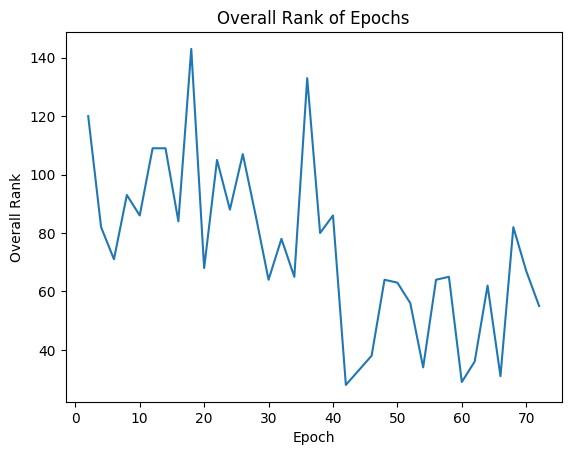

In [9]:
#Plot the overall rank
plt.figure()
plt.plot(list(overall_rank.keys()), list(overall_rank.values()))
plt.xlabel("Epoch")
plt.ylabel("Overall Rank")
plt.title("Overall Rank of Epochs")
plt.show()

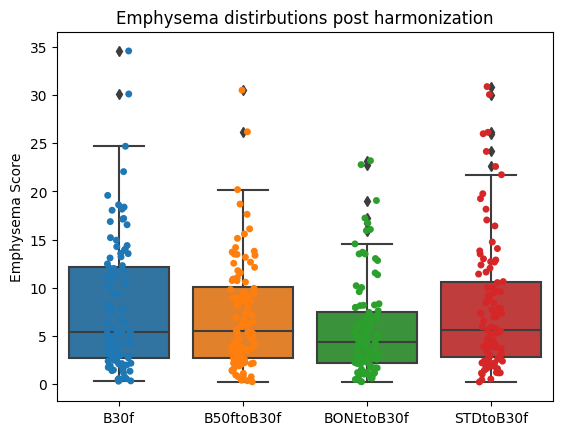

In [12]:
#Epoch 16 emphysema plots 
b50ftob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_42", "B50ftoB30f_emphysema", "emph.csv"))
b50ftob30f = b50ftob30f.sort_values(by = "pid")
bonetob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_42", "BONEtoB30f_emphysema", "emph.csv"))
bonetob30f = bonetob30f.sort_values(by = "pid")
stdtob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_42", "STDtoB30f_emphysema", "emph.csv"))
stdtob30f = stdtob30f.sort_values(by = "pid")

#Boxplot of the predicted values against reference b30f
plt.figure()
sns.boxplot(data = [b30f["emph_score"], b50ftob30f["emph_score"], bonetob30f["emph_score"], stdtob30f["emph_score"]])
sns.stripplot(data = [b30f["emph_score"], b50ftob30f["emph_score"], bonetob30f["emph_score"], stdtob30f["emph_score"]])
plt.xticks([0,1,2,3], ["B30f", "B50ftoB30f", "BONEtoB30f", "STDtoB30f"])
plt.ylabel("Emphysema Score")
plt.title("Emphysema distirbutions post harmonization")
plt.show()
